# Sticky information and consumption response

## Preliminary

In [1]:
# imports

# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.optimize import newton

# from HANKStickyModel import HANKStickyModelClass
from HA_simple import HAsimpleModel

# Overview
Analysis about the interaction of sticky information and the consumption response:
1. Show how sticky information is able to match high MPCs and how it affects iMPCs.

2. Show how this is able to match sluggishness in response to shocks

3. Show importance of anticipation effects in HANK and with respect to sticky information + fiscal policy.

(a) Maybe partial equilibrium decomposition first?

In [2]:
model = HAsimpleModel.HAsimpleModelClass(par={'beta_mean': 0.9923})
model.find_ss()
model._compute_jac_hh()
print(f'beta: {model.par.beta_mean}')
print(f'annualized beta: {model.par.beta_mean**4}')

beta: 0.9923659650599889
annualized beta: 0.9698117549730303


In [3]:
ss = model.ss
par = model.par

# Comparison to estimates from Fagereng et al. (2021)
iMPCs play an important role in the transmission of fiscal policy. The sticky information hereby affects the iMPCs to future income shocks, but leave the response to a shock in period 0 unaffected.
Here, I will show how the model matches the data by Fagereng et al. (2021) that provide (probably the most credible) estimates about MPCs to an unexpected income shock.

In [4]:
# WRONG!?

In [4]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]
MPCs_model = [
    np.sum([model.jac_hh[('C_hh', 'y')][0, (t*4 + i)] / (1 + ss.r) ** (t*4 + i) for i in range(4)])
    for t in [0,1,2,3,4,5]
]
MPCs_model_ey = [
    np.sum([model.jac_hh[('C_hh', 'ey')][0, (t*4 + i)] / (1 + ss.r) ** (t*4 + i) for i in range(4)])
    for t in [0,1,2,3,4,5]
]

Note that their estimates are yearly, while my model is in quarterly frequency. For the first graph, I will compare the annual estimates to my annual iMPC. Specifically to
$$ \sum_{i=t}^{t+3} \frac{\partial C_i}{\partial y_0} (\frac{1}{1+r^{ss}})^{i}, t\in{0,1,2,3,4,5} $$

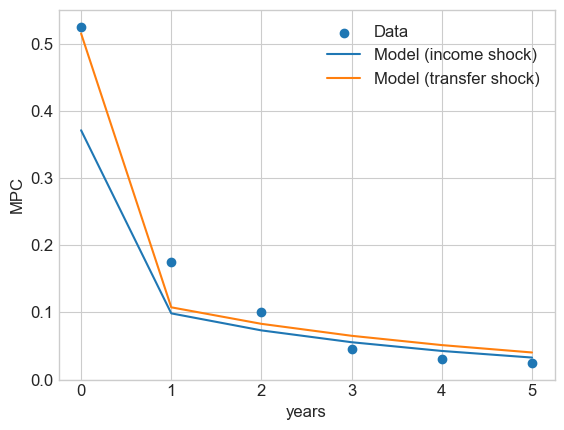

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
ax.plot(np.arange(6), MPCs_model, label='Model (income shock)')
ax.plot(np.arange(6), MPCs_model_ey, label='Model (transfer shock)')
ax.set_ylabel("MPC")
ax.set_xlabel('years')
ax.legend()

In [6]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]
MPCs_model = [
    np.sum([model.jac_hh[('C_hh', 'y')][(t*4 + i), 0] / (1 + ss.r) ** (t*4 + i) for i in range(4)])
    for t in [0,1,2,3,4,5]
]
MPCs_model_ey = [
    np.sum([model.jac_hh[('C_hh', 'ey')][(t*4 + i), 0] / (1 + ss.r) ** (t*4 + i) for i in range(4)])
    for t in [0,1,2,3,4,5]
]

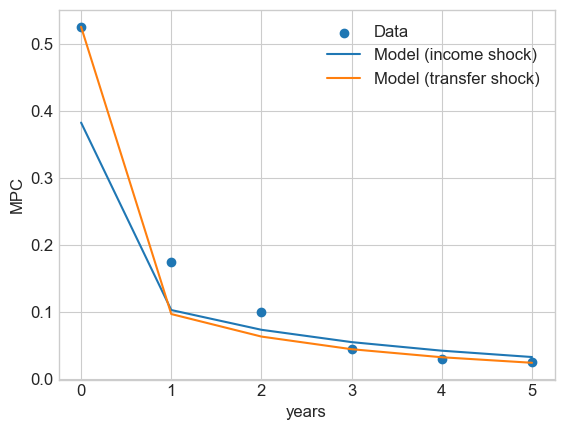

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
ax.plot(np.arange(6), MPCs_model, label='Model (income shock)')
ax.plot(np.arange(6), MPCs_model_ey, label='Model (transfer shock)')
ax.set_ylabel("MPC")
ax.set_xlabel('years')
ax.legend()

As Fagereng et al. (2021) note, these estimates consist of time-averaged responses. "For example, the within-year response is an average across households who won 0 to 12 months ago, the year 1 response is an average across households who won 0 to 24 months ago, and the year 2 response is an average across households who won 12 to 36 months ago."
In order to allow a mapping to models, they  provide an approximation based on the power form
$$ mpc(t) = \theta_1 t^{\theta_2} $$ with $[\theta_1, \theta_2] = [0.629, 0.214]$. The quarterly MPC is then defined as
$$\theta_1 (t/4)^{\theta_2}$$.
This formulation allows to compare their estimates to the quarterly model formulation. Note, that this leads to an implicit assumption that each household experiences the income increase at the beginning of each quarter.
-> not really realistic?

# Consumption response

In [9]:
model_sticky = model.copy()
model_sticky.par.inattention = 0.935

model.par.inattention = model_sticky.par.inattention
model_sticky.jac_hh= model._compute_sticky_jacs_hh(model.jac_hh)
model.par.inattention = 0.0

In [10]:
def plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho):

    nrows = len(compare_outputs)
    ncols = len(compare_inputs)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows), dpi=100)

    fig = plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

    return fig

def plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump=0.01, shocks_rho=0.9, shock_series=None, linestyle='-', decompose=False):

    fig_i = 0

    use_custom_series = True if isinstance(shock_series, np.ndarray) else False

    for output in compare_outputs:
        for i_s, shock in enumerate(compare_inputs):

            T = np.array([m.par.T for m in model_list]).min()
            if not use_custom_series:
                shock_series =  shocks_jump[i_s]*shocks_rho[i_s]**np.arange(T)

            ax = fig.axes[fig_i]
            fig_i += 1
            ax.set_title(f'Shock to {shock}')
            # ax.set_title(f'{shock}_shock on {output} (in %)')
            ax.set_xlabel('t (in quarters)')
            y_label = output.split('_')[0]
            ax.set_ylabel(f'$\Delta {y_label}_t$ (in %)')

            for i_m, m in enumerate(model_list):
                jac = m.jac_hh[(output, shock)].copy()
                ss_value = m.ss.__dict__[output]
                IRF_abs = jac @ shock_series
                IRF_perc = (IRF_abs / ss_value) * 100
                # plot
                ax.plot(np.arange(plot_periods), IRF_perc[:plot_periods], label=label_list[i_m], linestyle=linestyle)
                if decompose:
                    decompose_PE(ax, m, (output, shock), shock_series, ss_value, plot_periods)
            ax.legend()

    return fig

def decompose_PE(ax, model, output_input, shock_series, ss_value, plot_periods):

    jac = model.jac_hh[output_input]

    # get hh jacs for theta = 1
    model_full_sticky = model.copy()
    if model.par.inattention > 0.0:
        model_full_sticky = model.copy()
        model_full_sticky.par.inattention = 0.0
        model_full_sticky._compute_jac_hh()
    model_full_sticky.par.inattention = 1.0
    jac_full_sticky = model_full_sticky._compute_sticky_jacs_hh(model_full_sticky.jac_hh)
    jac_full_sticky = jac_full_sticky[output_input]

    # Direct impact effect of shock
        # All elements except the diagonal to zero.
    jac_direct = np.diag(np.diag(jac_full_sticky))

    # Ex-post distributional effects
        # Elements on and above diagonal to zero.
    jac_post = jac_full_sticky.copy()
    for t in range(jac_post.shape[0]):
        jac_post[t,t] = 0.0

    # Anticipation effects
    jac_anticipation = jac - jac_direct - jac_post

    IRF = jac @ shock_series
    IRF_direct = jac_direct @ shock_series
    IRF_expost = jac_post @ shock_series
    IRF_anticip = jac_anticipation @ shock_series

    assert np.isclose(IRF - (IRF_direct + IRF_anticip + IRF_expost), 0.0).all()

    ax.plot(np.arange(plot_periods), (IRF_direct[:plot_periods] / ss_value)*100, label=f"impact", linestyle="--")

    ax.plot(np.arange(plot_periods), (IRF_anticip[:plot_periods] / ss_value)*100, label=f"anticipation", linestyle="--")

    ax.plot(np.arange(plot_periods), (IRF_expost[:plot_periods] / ss_value)*100, label=f"ex-post", linestyle="--")

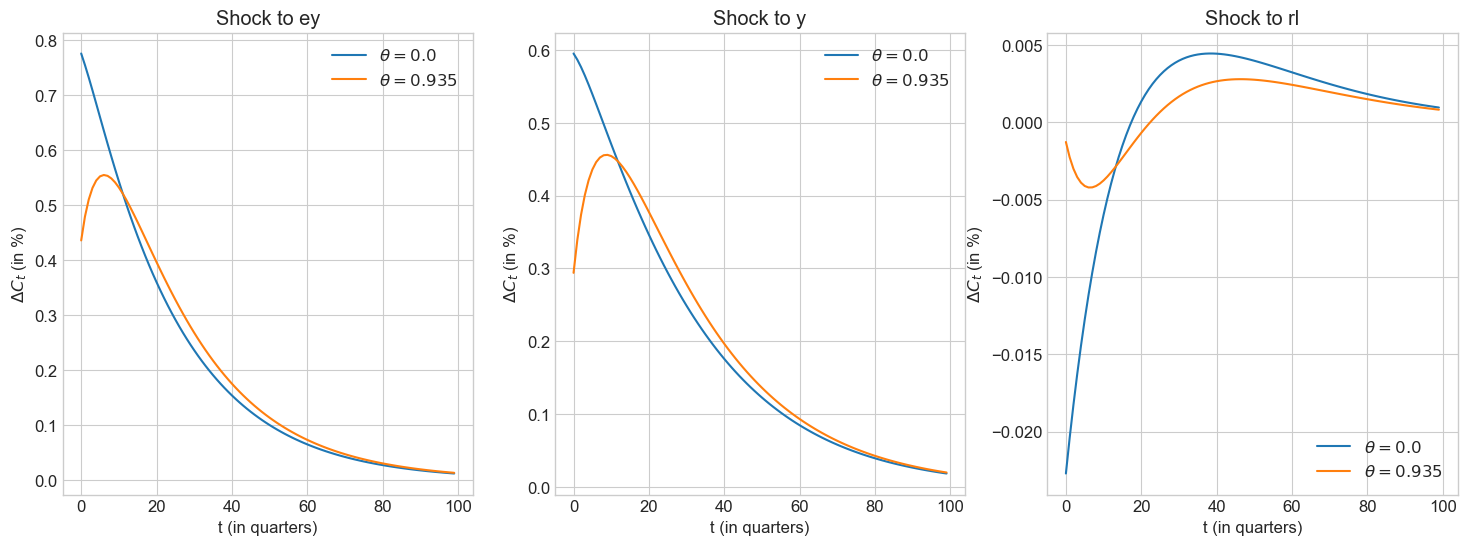

In [11]:
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['ey', 'y', 'rl']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y, 0.01 * ss.y, 0.01 * abs(ss.rl)]
shocks_rho = [0.95, 0.95, 0.95]
# shocks_jump = [0.01 * (1 - ss.tau) * ss.wN, -0.01 * ss.tau, 0.01*ss.wN, 0.01 * abs(ss.rl), 0.01 * ss.ra]
# shocks_rho =[0.966, 0.966, 0.966, 0.966, 0.966]

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['no intertemp'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)


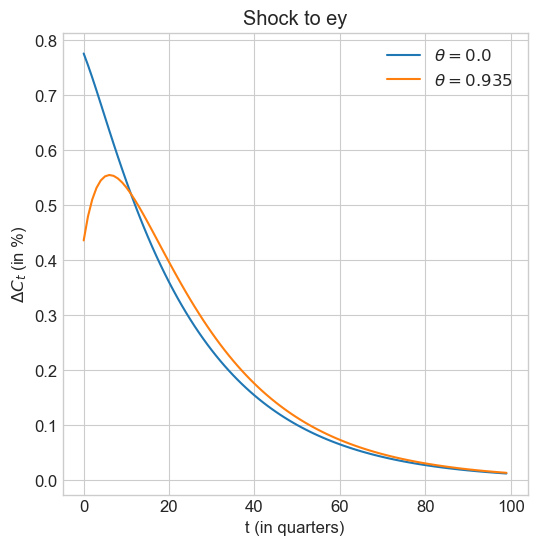

In [12]:
compare_inputs = ['ey']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

# Decomposition

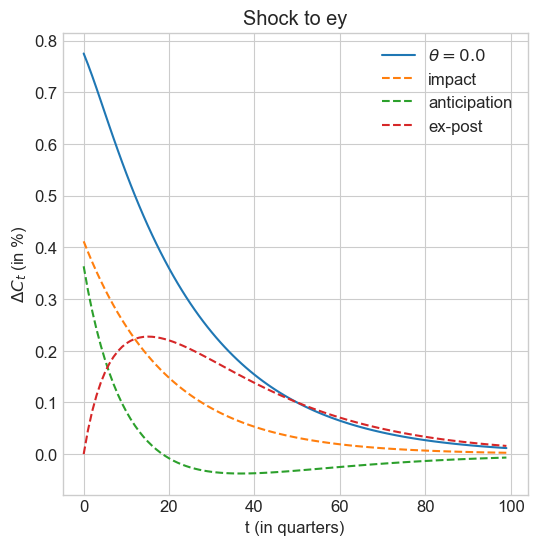

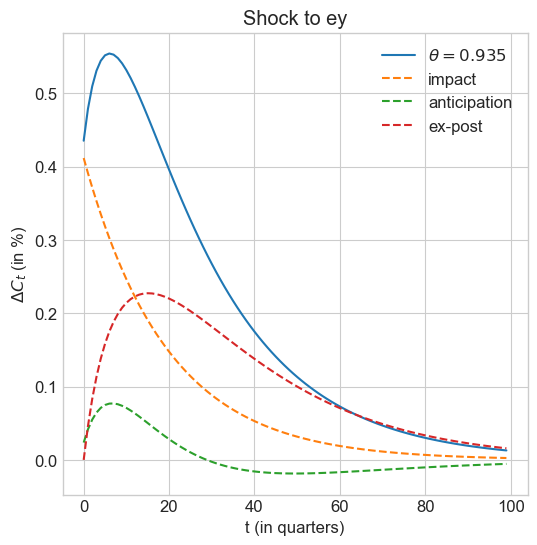

In [13]:
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

# fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

ncols = len(compare_outputs)
nrows = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[0]], [label_list[0]], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho,
                 decompose=True)
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[1]], [label_list[1]], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, decompose=True)

In [14]:
model_full_sticky = model.copy()
model_full_sticky.par.inattention = 1.0

model.par.inattention = model_full_sticky.par.inattention
model_full_sticky.jac_hh= model._compute_sticky_jacs_hh(model.jac_hh)
model.par.inattention = 0.0

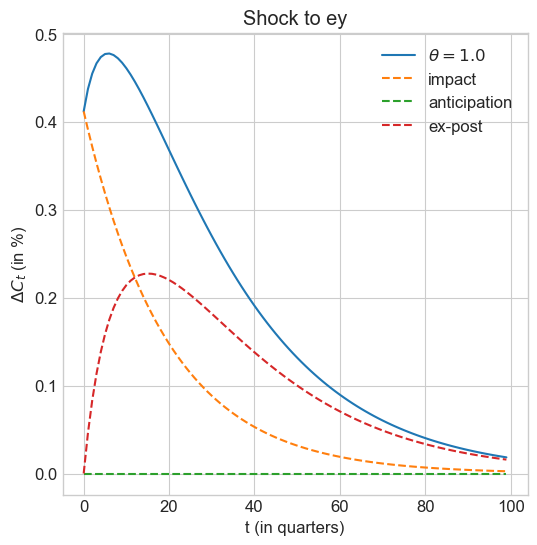

In [15]:
model_list = [model_full_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = 100 # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

# fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

ncols = len(compare_outputs)
nrows = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[0]], [label_list[0]], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho,
                 decompose=True)

# Dependence on persistence
One important note is that the humps are highly dependent on the persistence of the shock. If the shocks are not highly persistent, income and substitution effects are muted and so is the impact of sticky information.

Illustration of this using different persistence levels that all increase aggregate labor income by 5% over different time horizons:

sum of shocks: 0.005
rhos: [0.95, 0.9, 0.8]
jumps: [0.00026, 0.0005, 0.001]
jump_hump: 0.00014


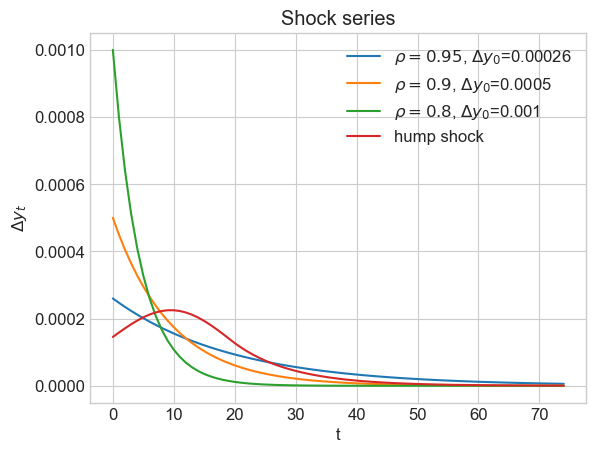

In [16]:
T = 75
T_max = model.par.T
target = 0.05
print(f"sum of shocks: {target:.3f}")


def residual_jump(jump, *args):
    rho, target = args
    shock_series = jump * rho ** np.arange(T)
    return abs(target - sum(shock_series))


def series_hump(T, jump):
    for t in range(T):
        if t < 20:
            rho = (110 - t) / 100
        else:
            rho = 0.9
        if t > 0:
            shock_lag = shock_series[t - 1]
        else:
            shock_lag = jump / 1.06
        shock_series[t] = shock_lag * rho
    return shock_series


def residual_hump(jump, *args):
    T, target = args
    shock_series = series_hump(T, jump)
    return abs(target - sum(shock_series))


rho = [0.95, 0.9, 0.8]

jump = [round(newton(residual_jump, 0.01, args=[r, target]), 5) for r in rho]
print(f'rhos: {rho}')
print(f'jumps: {jump}')

fig, ax = plt.subplots()
ax.set_title("Shock series")
for i_r, r_i in enumerate(rho):
    shock_series = jump[i_r] * r_i ** np.arange(T_max)
    ax.plot(np.arange(T), shock_series[:T], label=f"$\\rho={r_i}$, $\Delta y_0$={jump[i_r]}")

jump_hump = round(newton(residual_hump, 0.01, args=[T, target]), 5)
print(f'jump_hump: {jump_hump}')
shock_series = series_hump(T_max, jump_hump)
ax.plot(np.arange(T), shock_series[:T], label=f"hump shock")

ax.set_xlabel(f't')
ax.set_ylabel('$\Delta y_t$')

ax.legend()
plt.show()

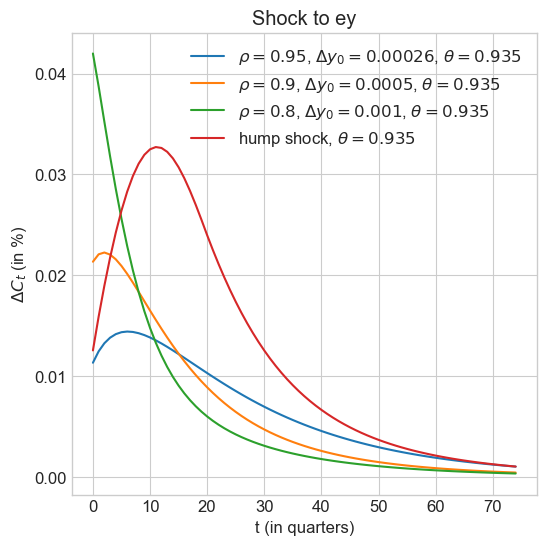

In [17]:
compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = 75 # model.par.T

# 1 % shocks to ss
ss = model_sticky.ss

jump_init = jump[0]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[0]]

fig = plot_PE_hh([model_sticky], [f'$\\rho={rho[0]}$, $\Delta y_0={jump[0]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.966$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[1]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[1]]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[1]}$, $\Delta y_0={jump[1]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.9$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')

jump_init = jump[2]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[2]]

fig = plotter_PE(fig, [model_sticky], [f'$\\rho={rho[2]}$, $\Delta y_0={jump[2]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
# fig = plotter_PE(fig, [model], ['$\\rho = 0.8$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho, linestyle='--')


shock_series = series_hump(T, jump_hump)
fig = plotter_PE(fig, [model_sticky], [f'hump shock, $\\theta={model_sticky.par.inattention}$'], compare_outputs,
                 compare_inputs, plot_periods, shock_series=shock_series)



# For Appendix
To-do:
- show responses to rl, ra?
- show how things change with lower MPCs
- distributional effects

## Decomposition for y shock

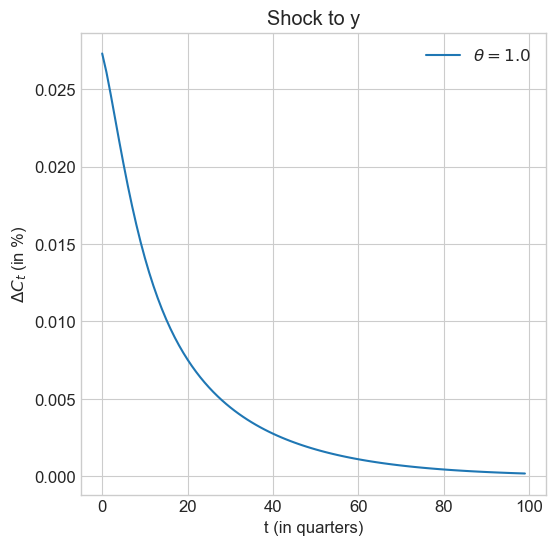

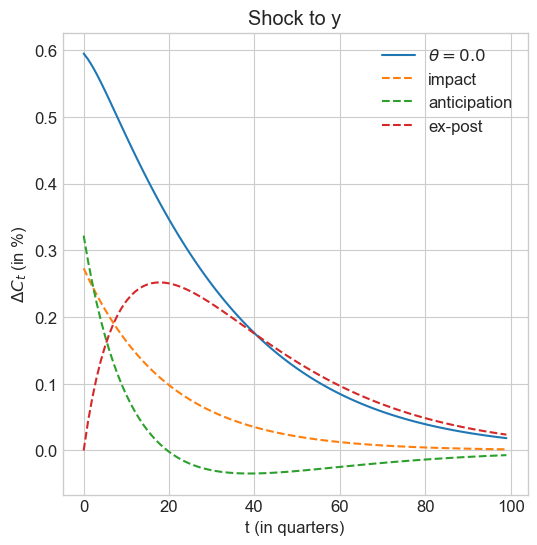

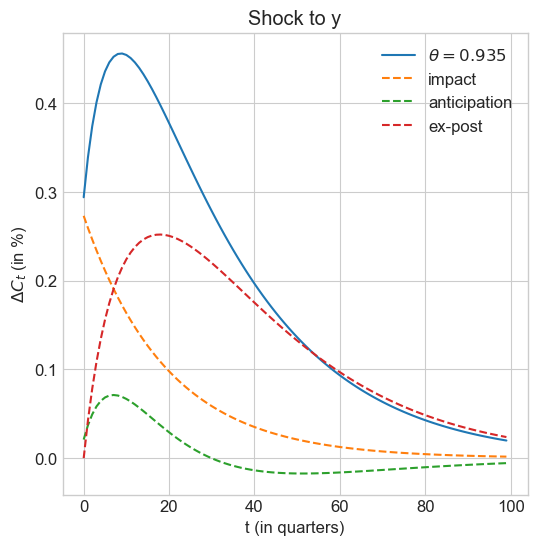

In [18]:
compare_inputs = ['y']

plot_periods = 100  # model.par.T

# 1 % jump in income
ss = model_sticky.ss

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']

compare_outputs = ['C_hh']

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

# fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

ncols = len(compare_outputs)
nrows = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[0]], [label_list[0]], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho,
                 decompose=True)
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_list[1]], [label_list[1]], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho, decompose=True)

## Theta sensitivity

In [19]:
def decompose_PE_sensitivity_theta(model, output_input, shock_series, theta_list ,plot_periods, ss_value):

    fig = plt.figure(figsize=(6*2, 6), dpi=100)
    ax_IRF = fig.add_subplot(1,2,1)
    ax = fig.add_subplot(1,2,2)

    model_no_sticky = model.copy()
    if model.par.inattention > 0.0:
        model_no_sticky = model.copy()
        model_no_sticky.par.inattention = 0.0
        model_no_sticky._compute_jac_hh()
    model_no_sticky.par.inattention = 1.0
    jac_full_sticky = model_no_sticky._compute_sticky_jacs_hh(model_no_sticky.jac_hh)
    jac_full_sticky = jac_full_sticky[output_input]

    # Direct impact effect of shock
        # All elements except the diagonal to zero.
    jac_direct = np.diag(np.diag(jac_full_sticky))

    # Ex-post distributional effects
        # Elements on and above diagonal to zero.
    jac_post = jac_full_sticky.copy()
    for t in range(jac_post.shape[0]):
        jac_post[t,t] = 0.0

    IRF_direct = jac_direct @ shock_series
    IRF_expost = jac_post @ shock_series

    for theta in theta_list:

        model_temp = model_no_sticky.copy()
        model_temp.par.inattention = theta
        jac = model_temp._compute_sticky_jacs_hh(model_temp.jac_hh)
        jac = jac[output_input]

        # Anticipation effects
        jac_anticipation = jac - jac_direct - jac_post

        IRF = jac @ shock_series

        IRF_anticip = jac_anticipation @ shock_series

        assert np.isclose(IRF - (IRF_direct + IRF_anticip + IRF_expost), 0.0).all()

        ax_IRF.plot(np.arange(plot_periods), (IRF[:plot_periods] / ss_value)*100, label=f"$\\theta={theta}$", linestyle="-")

        ax.plot(np.arange(plot_periods), (IRF_anticip[:plot_periods] / ss_value)*100, label=f"$\\theta={theta}$", linestyle="-")

    ax_IRF.set_title('IRF from shock to ey')
    # ax.set_title(f'{shock}_shock on {output} (in %)')
    ax_IRF.set_xlabel('t (in quarters)')
    ax_IRF.set_ylabel(f'$\Delta C_t$ (in %)')
    ax_IRF.legend()

    ax.set_title('Anticipation effect')
    # ax.set_title(f'{shock}_shock on {output} (in %)')
    ax.set_xlabel('t (in quarters)')
    ax.set_ylabel(f'$\Delta C_t$ (in %)')
    ax.legend()

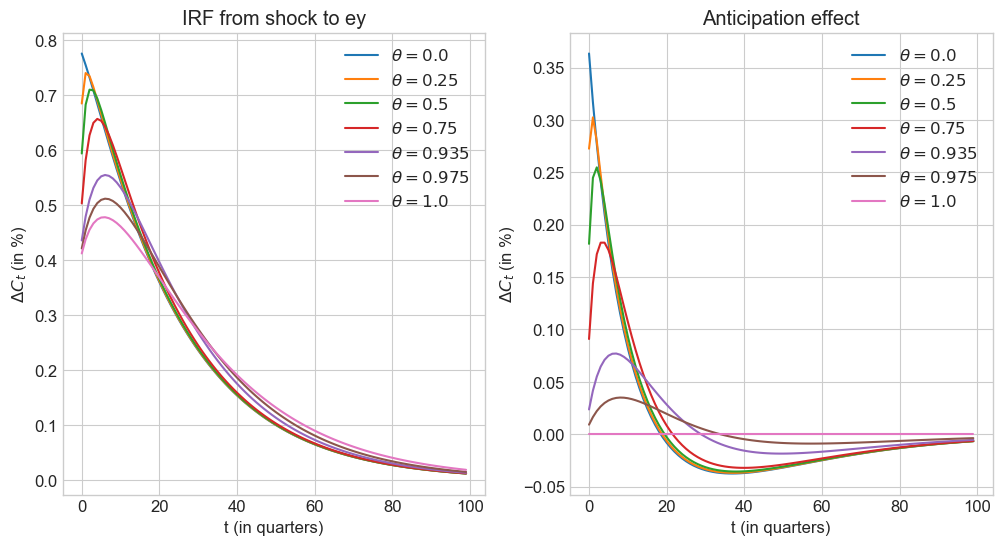

In [20]:
shocks_jump = [0.01 * ss.y]
shocks_rho = [0.95]

T = model.par.T
shock_series =  shocks_jump[0]*shocks_rho[0]**np.arange(T)
ss_value = model.ss.__dict__['C_hh']
plot_periods = 100

theta_list = [0.0, 0.25, 0.5, 0.75, 0.935, 0.975, 1.0]

decompose_PE_sensitivity_theta(model, ('C_hh', 'ey'), shock_series, theta_list ,plot_periods, ss_value)

## iMPCs

In [21]:
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def plot_jacs(model, s_list=None, dx=1e-4, inputs_outputs=[], max_T=model.par.T, inattention=0.935):
    """ compute and plot hh Jacobians with direct and fake news method
        - difference to GEModelTools function: plot only selected Jacobians.

        :param input_output: Jacobians to plot as list of elements in the form of ('outputname', 'inputname')."""

    model_jac_temp = deepcopy(model.jac_hh)    # save original model jacs and replace again later as not all Jacobians might be caluclated

    if s_list is None:
        s_list = list(np.arange(0, max_T, max_T // 4))

    if len(inputs_outputs) > 0:
        inputs_hh_all = set([inp[1] for inp in plot_list if inp[1]])
    else:
        inputs_hh_all = model.inputs_hh_all

    # a. no sticky jacs
    if model.par.inattention == 0:
        jac_hh_no_sticky = model.jac_hh
    else:
        jac_hh_save = model.jac_hh
        model._compute_jac_hh(dx=dx, do_print=True, do_direct=True, s_list=s_list, inputs_hh_all=inputs_hh_all)
        jac_hh_sticky = model.jac_hh
        model.jac_hh = jac_hh_save

    # b. sticky
    if model.par.inattention == inattention:
        jac_hh_sticky = model.jac_hh
    else:
        inattention_save = model.par.inattention

        model.par.inattention = inattention
        jac_hh_sticky = model._compute_sticky_jacs_hh(model.jac_hh)

        model.par.inattention = inattention_save

    # c. compare

    def jac_add_subplot(input_output, n_inputs_outputs):
        jac_hh_var_no_sticky = jac_hh_no_sticky[input_output]
        jac_hh_var = jac_hh_sticky[input_output]

        ax1 = fig.add_subplot(n_inputs_outputs, 3, i * 2 + 1)
        ax2 = fig.add_subplot(n_inputs_outputs, 3, i * 2 + 2)
        ax_diff = fig.add_subplot(n_inputs_outputs, 3, i * 2 + 3)

        # ax.set_title(f'Jac {input_output}')
        # ax_diff.set_title('$\partial C_t^{FI} / \partial y_s - \partial C_t / \partial y_s$')

        for j, s in enumerate(s_list):
            ax1.plot(np.arange(max_T), jac_hh_var_no_sticky[:max_T, s], color=colors[j], label=f's = {s}')
            ax2.plot(np.arange(max_T), jac_hh_var[:max_T, s], color=colors[j], ls='-', label=f's = {s}')
            ax1.set_xlabel('t (in quarters)')
            ax2.set_xlabel('t (in quarters)')
            # ax.set_ylabel(f'$\partial C_t / \partial y_s$')
            ax1.set_ylabel('$J_{t,s}^{C,ey,FI}$')
            ax2.set_ylabel('$J_{t,s}^{C,ey}$')

            diff = jac_hh_var[:max_T, s] - jac_hh_var_no_sticky[:max_T, s]
            ax_diff.plot(np.arange(max_T), diff, color=colors[j], label=f's = {s}')
            ax_diff.set_xlabel('t (in quarters)')
            # ax_diff.set_ylabel('$\partial C_t^{FI} / \partial y_s - \partial C_t / \partial y_s$')
            ax_diff.set_ylabel('$J_{t,s}^{C,ey,FI} - J_{t,s}^{C,ey}$')

            # list_diffs.append([
            #     f'{input_output}, s = {s}',
            #     abs(diff).max(),
            #     (abs(diff).max()/ abs(jac_hh_var_no_sticky[abs(diff).argmax(), s])) * 100
            # ])

        return ax1, ax2, ax_diff

    i = 0

    if len(inputs_outputs) == 0:
        fig = plt.figure(figsize=(6 * 3, len(model.outputs_hh) * len(model.inputs_hh_all) * 4), dpi=100)

        n_inputs_outputs = len(model.inputs_hh_all) * len(model.outputs_hh)
        for inputname in model.inputs_hh_all:
            for outputname in model.outputs_hh:

                input_output = (f'{outputname.upper()}_hh', inputname)

                ax1, ax2, ax_diff = jac_add_subplot(input_output, n_inputs_outputs)

                if i == 0:
                    ax.legend(frameon=True)
                    ax_diff.legend(frameon=True)
                i += 1
    else:
        fig = plt.figure(figsize=(6 * 3, len(inputs_outputs)*4), dpi=100)

        n_inputs_outputs = len(inputs_outputs)
        for input_output in inputs_outputs:

            ax1, ax2, ax_diff = jac_add_subplot(input_output, n_inputs_outputs)

            if i == 0:
                ax1.legend(frameon=True)
                ax2.legend(frameon=True)
                ax_diff.legend(frameon=True)
            i += 1

    model.jac_hh = model_jac_temp


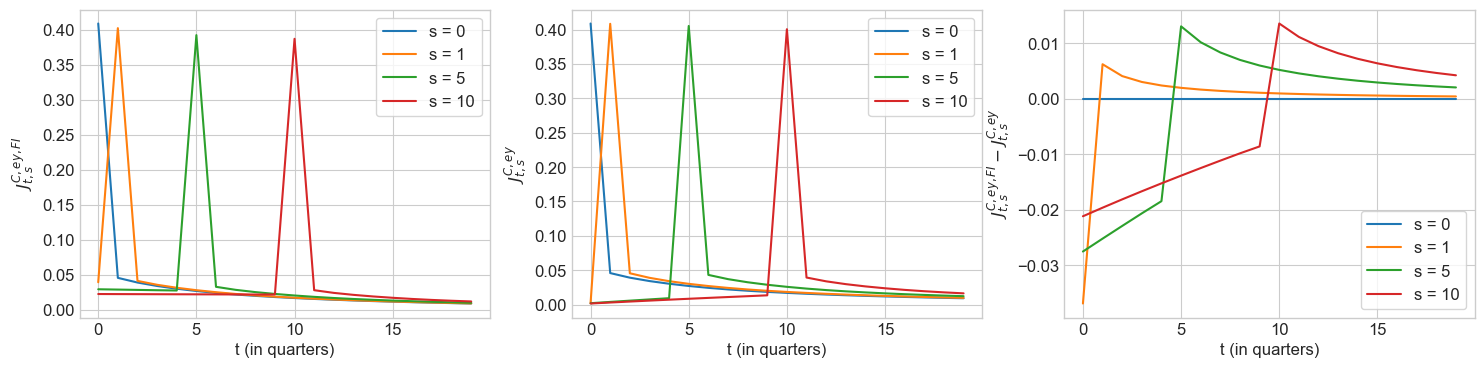

In [22]:
s_list = [0,1,5,10]
plot_list = [('C_hh', 'ey')]
plot_jacs(model, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.935)

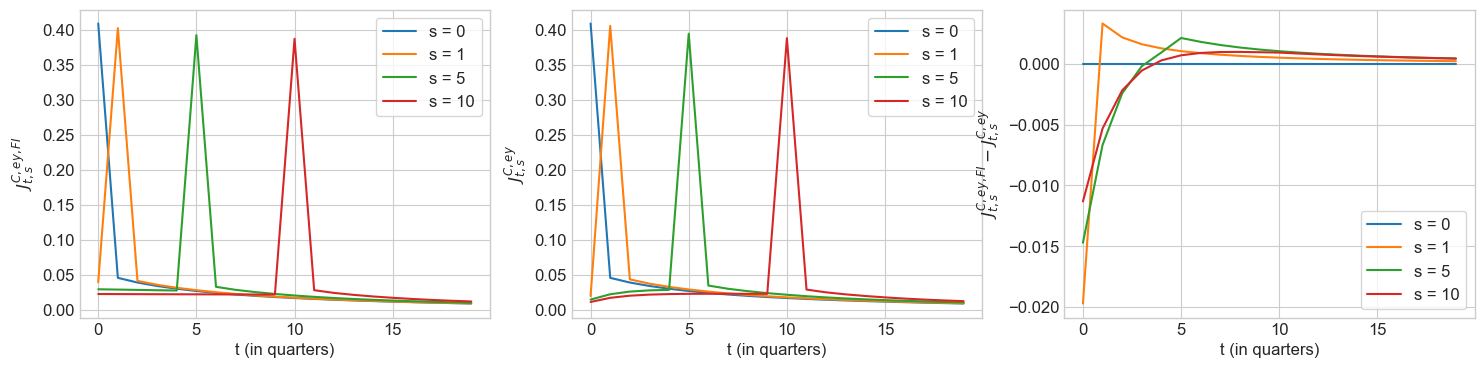

In [23]:
plot_jacs(model, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.5)

## Interest rate changes

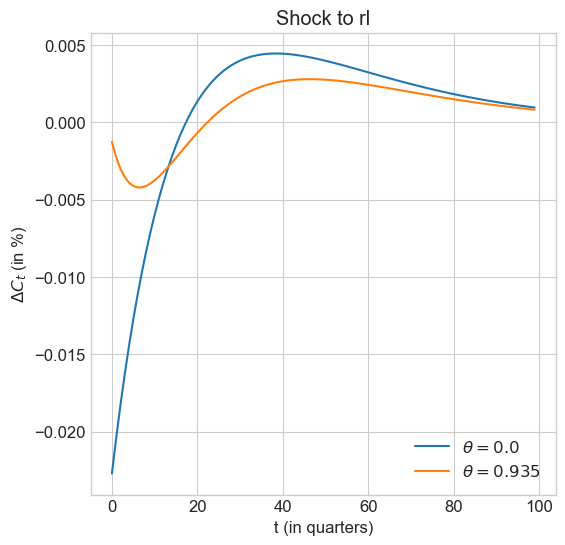

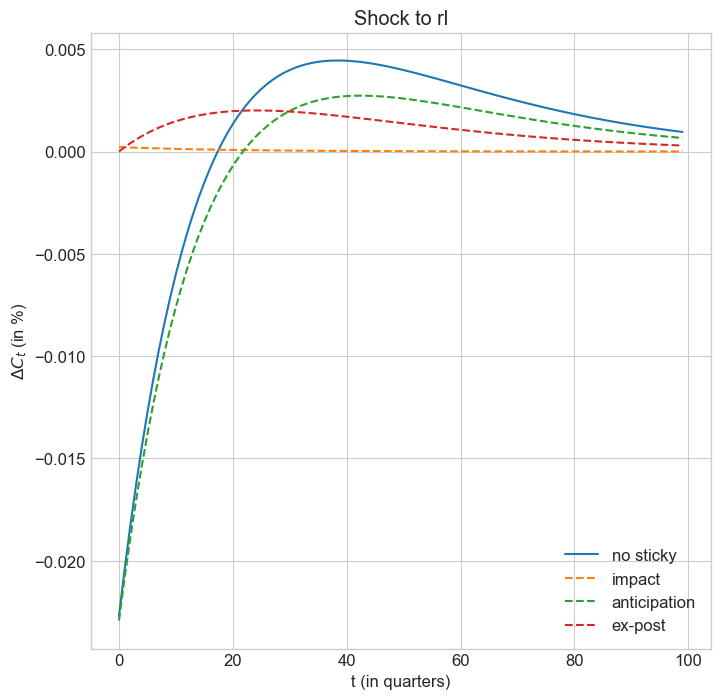

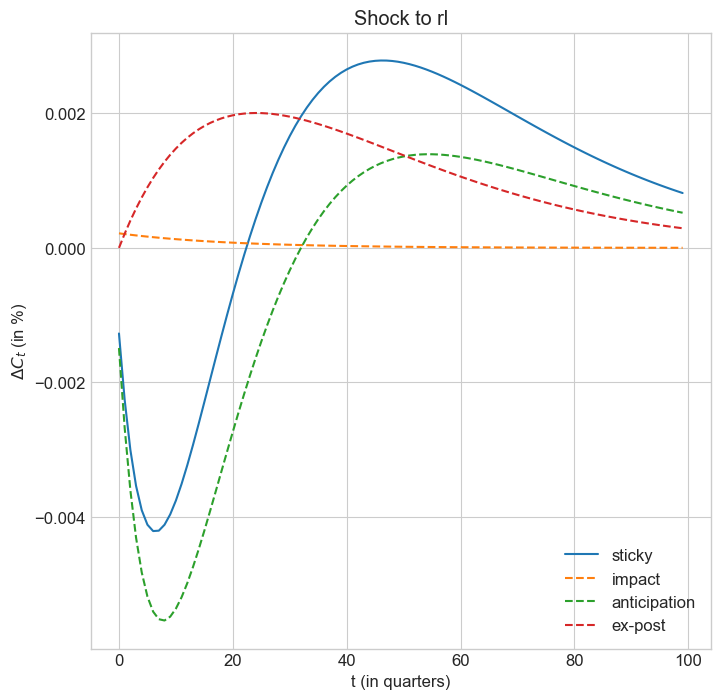

In [24]:
model_list = [model, model_sticky]
label_list = [f'$\\theta = {model_list[0].par.inattention}$', f'$\\theta = {model_list[1].par.inattention}$']

compare_outputs = ['C_hh']
compare_inputs = ['rl']

plot_periods = 100  # model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * abs(ss.rl)]
shocks_rho = [0.95]

fig = plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * nrows), dpi=100)
fig = plotter_PE(fig, [model], ['no sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho,
                 decompose=True)
nrows = len(compare_outputs)
ncols = len(compare_inputs)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky], ['sticky'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho, decompose=True)

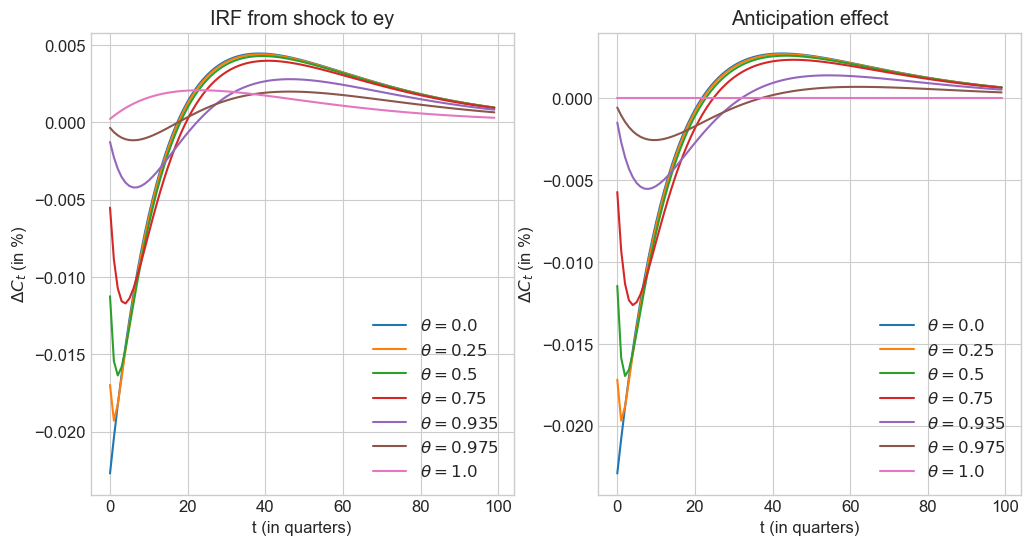

In [25]:
T = model.par.T
shock_series =  shocks_jump[0]*shocks_rho[0]**np.arange(T)
ss_value = model.ss.__dict__['C_hh']
plot_periods = 100

theta_list = [0.0, 0.25, 0.5, 0.75, 0.935, 0.975, 1.0]

decompose_PE_sensitivity_theta(model, ('C_hh', 'rl'), shock_series, theta_list ,plot_periods, ss_value)

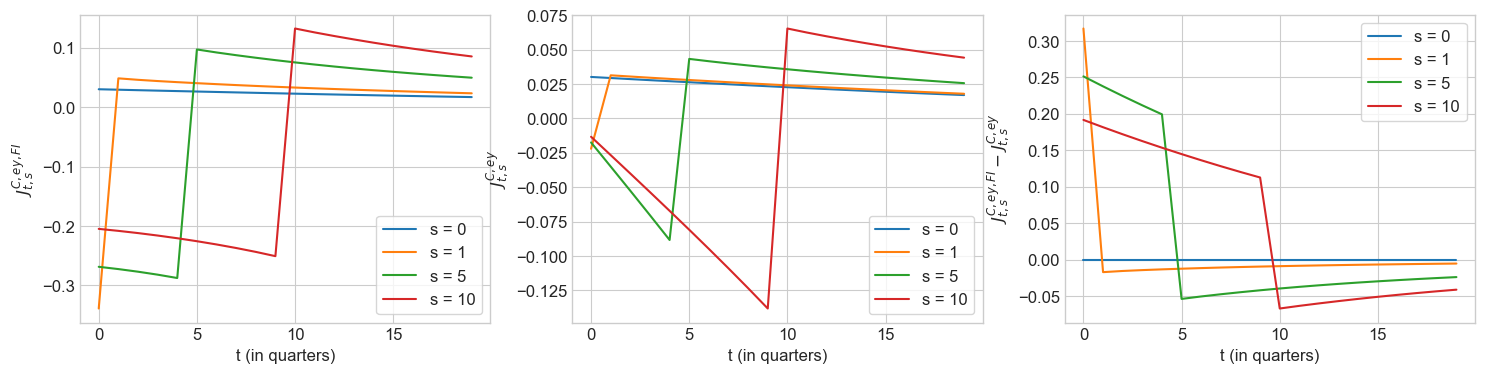

In [26]:
s_list = [0,1,5,10]
plot_list = [('C_hh', 'rl')]
plot_jacs(model, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.935)

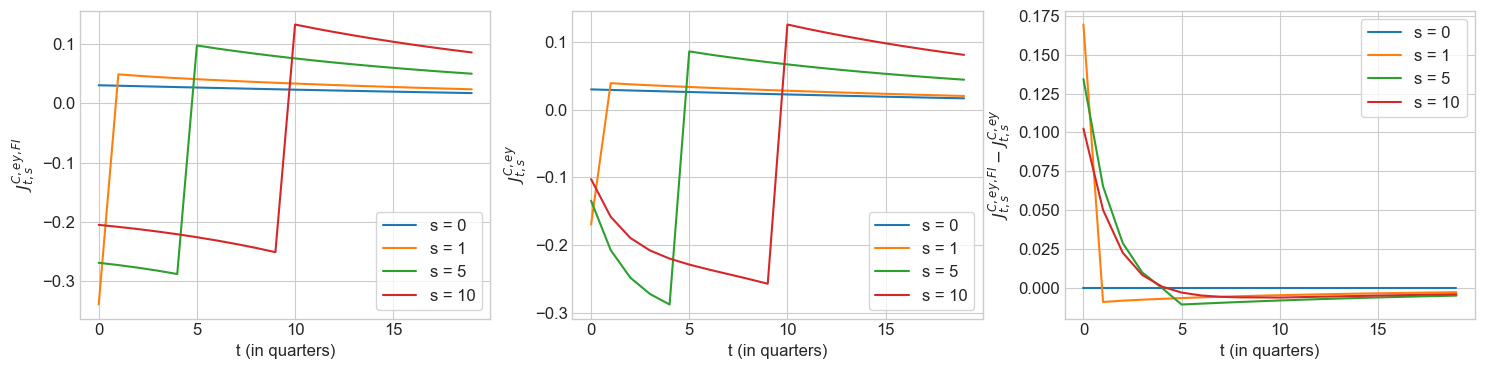

In [27]:
plot_jacs(model, s_list=s_list, max_T=20, inputs_outputs=plot_list, inattention=0.5)

## More graphs on persistence

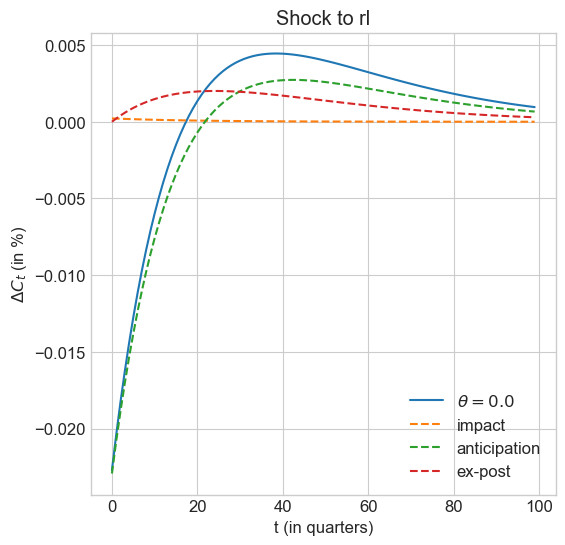

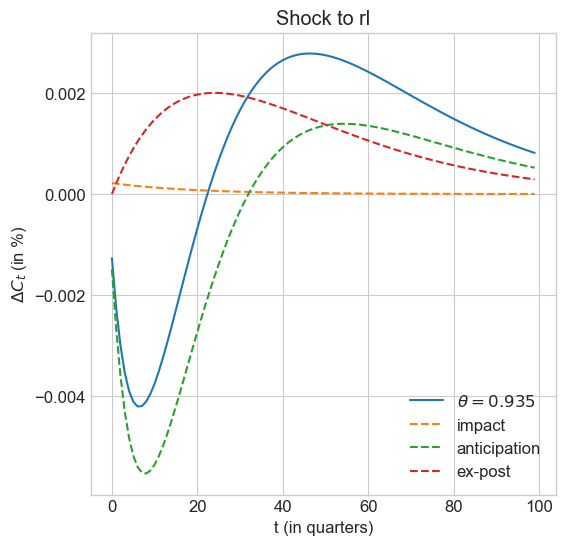

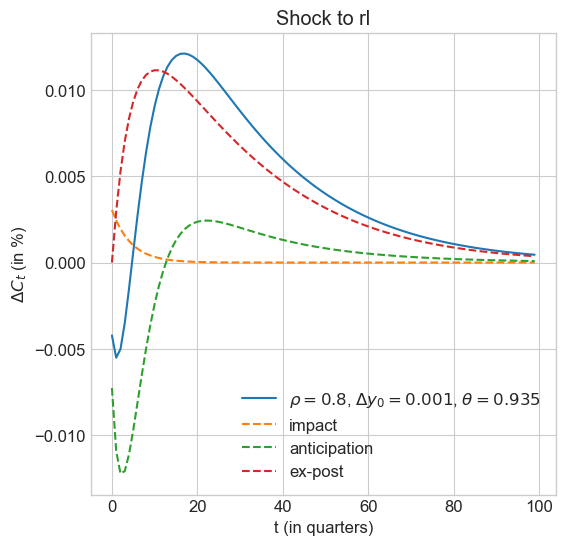

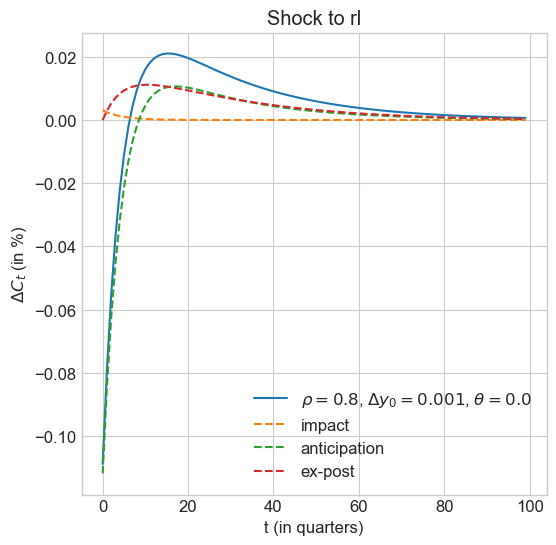

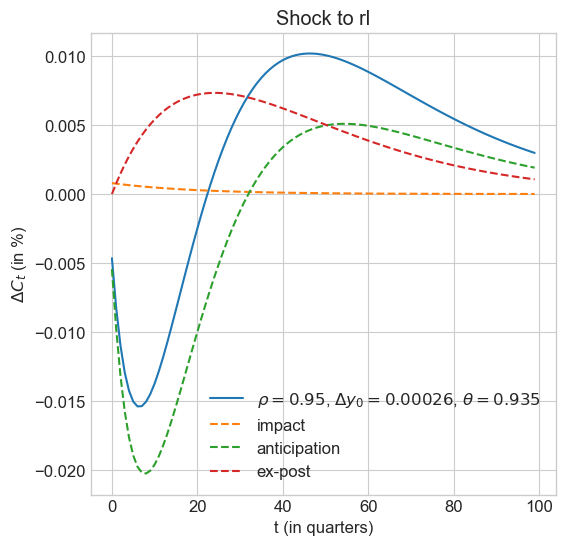

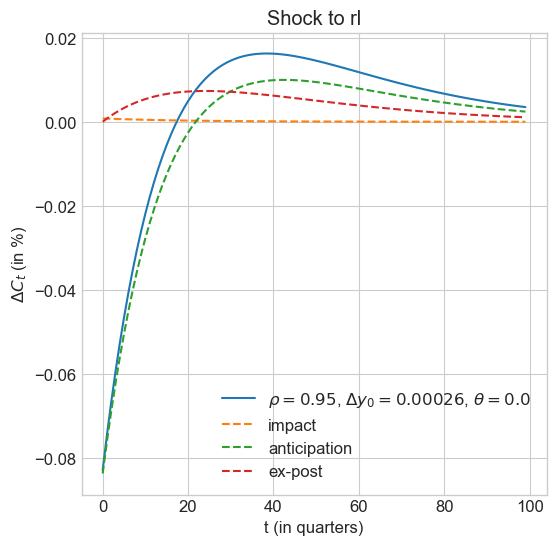

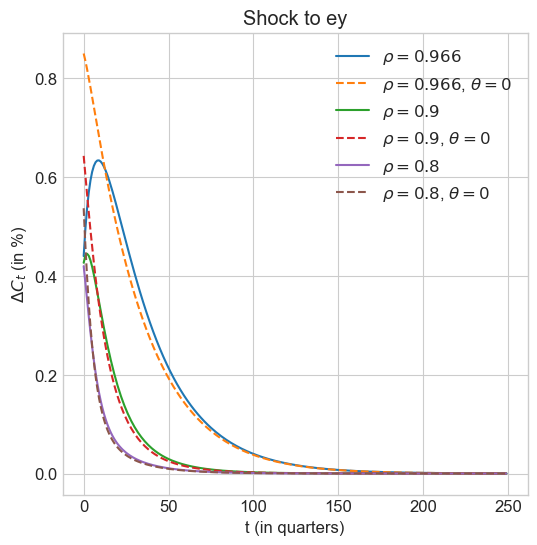

In [28]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model], [f'$\\theta = {model.par.inattention}$'], compare_outputs, compare_inputs,
                 plot_periods=100, shock_series=shock_series,
                 decompose=True)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky], [f'$\\theta = {model_sticky.par.inattention}$'], compare_outputs, compare_inputs,
                 plot_periods=100, shock_series=shock_series,
                 decompose=True)
jump_init = jump[2]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[2]]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky],
                 [f'$\\rho={rho[2]}$, $\Delta y_0={jump[2]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model], [f'$\\rho={rho[2]}$, $\Delta y_0={jump[2]}$, $\\theta={model.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)
jump_init = jump[0]
shocks_jump = [jump_init * ss.y]
shocks_rho = [rho[0]]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model_sticky],
                 [f'$\\rho={rho[0]}$, $\Delta y_0={jump[0]}$, $\\theta={model_sticky.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), dpi=100)
fig = plotter_PE(fig, [model], [f'$\\rho={rho[0]}$, $\Delta y_0={jump[0]}$, $\\theta={model.par.inattention}$'],
                 compare_outputs, compare_inputs, 100, shocks_jump, shocks_rho, decompose=True)
compare_outputs = ['C_hh']
compare_inputs = ['ey']

plot_periods = model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.y]
shocks_rho = [0.966]

fig = plot_PE_hh([model_sticky], ['$\\rho = 0.966$'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.966$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods,
                 shocks_jump, shocks_rho, linestyle='--')

shocks_rho = [0.9]
fig = plotter_PE(fig, [model_sticky], ['$\\rho = 0.9$'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.9$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods,
                 shocks_jump, shocks_rho, linestyle='--')
# #
shocks_rho = [0.8]
fig = plotter_PE(fig, [model_sticky], ['$\\rho = 0.8$'], compare_outputs, compare_inputs, plot_periods, shocks_jump,
                 shocks_rho)
fig = plotter_PE(fig, [model], ['$\\rho = 0.8$, $\\theta=0$'], compare_outputs, compare_inputs, plot_periods,
                 shocks_jump, shocks_rho, linestyle='--')

## Dependence hump on MPC targets

In [29]:
model_04 = HAsimpleModel.HAsimpleModelClass(par={'MPC_target': 0.4, 'beta_mean': 0.9923329545899056})
model_02 = HAsimpleModel.HAsimpleModelClass(par={'MPC_target': 0.2, 'beta_mean': 0.997525797518567})
model_01 = HAsimpleModel.HAsimpleModelClass(par={'MPC_target': 0.1, 'beta_mean': 1.0010103635719383})

In [30]:
model_list = [model, model_04, model_02, model_01]

for m in model_list[1:]:
    m.find_ss()
    m._compute_jac_hh()

model_04_sticky = model_04.copy()
model_02_sticky = model_02.copy()
model_01_sticky = model_01.copy()
model_list_sticky = [model_sticky, model_04_sticky, model_02_sticky, model_01_sticky]

for i, m_sticky in enumerate(model_list_sticky[1:]):
    m = model_list[i+1]
    m_sticky.par.inattention = 0.935

    m.par.inattention = m_sticky.par.inattention
    m_sticky.jac_hh= m._compute_sticky_jacs_hh(m.jac_hh)
    m.par.inattention = 0.0

(0.0, 0.5502470815763574)

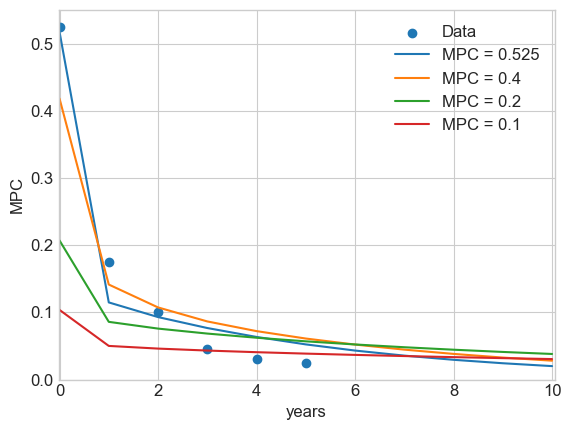

In [31]:
MPCs_data = [0.525, 0.175, 0.10, 0.045, 0.03, 0.025]
label_list = []
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(np.arange(6), MPCs_data, label='Data')
for m in model_list:
    MPCs_model = [m.jac_hh[('C_hh', 'ey')][0, (t * 4):(t * 4) + 4].sum() for t in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
    label = 'MPC = '+str(m.par.MPC_target)
    label_list.append(label)
    ax.plot(np.arange(11), MPCs_model, label=label)
ax.set_ylabel("MPC")
ax.set_xlabel('years')
ax.legend()
plt.xlim(xmin=-0.02, xmax=10.05)
plt.ylim(ymin=0.0)

(0.0, 0.6752939027273664)

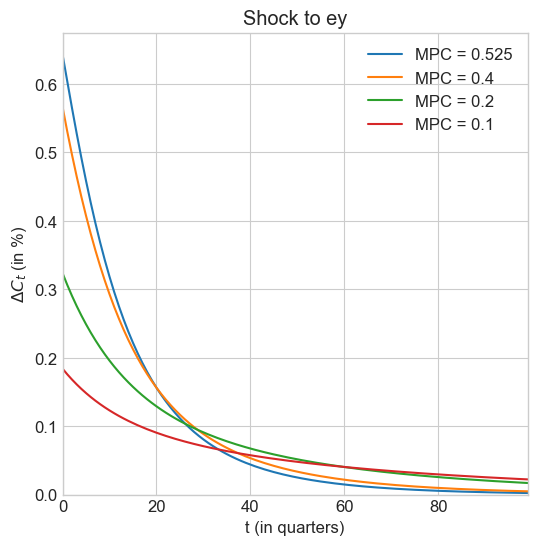

In [32]:
compare_inputs = ['ey']
compare_outputs = ['C_hh']
shocks_jump = [0.01 * m.ss.y for m in model_list]
shocks_rho = [0.9 for m in model_list]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
model_list = [model, model_04, model_02, model_01]
fig = plotter_PE(fig, model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
plt.xlim(xmin=0.0,xmax=99.0)
plt.ylim(ymin=0.0)

(0.0, 0.4672175340876691)

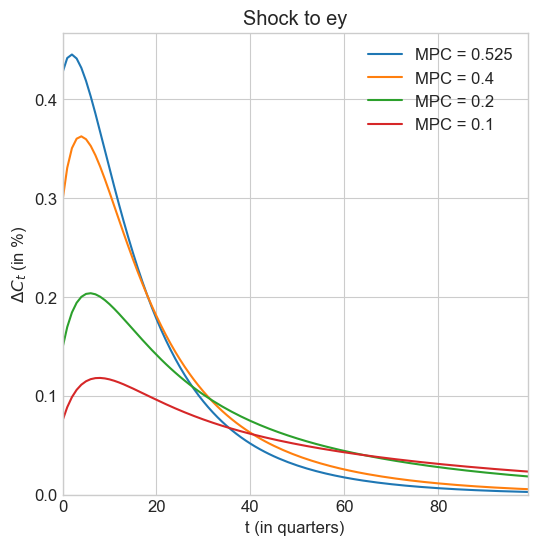

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
fig = plotter_PE(fig, model_list_sticky, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)
plt.xlim(xmin=0.0,xmax=99.0)
plt.ylim(ymin=0.0)

(0.0, 99.0)

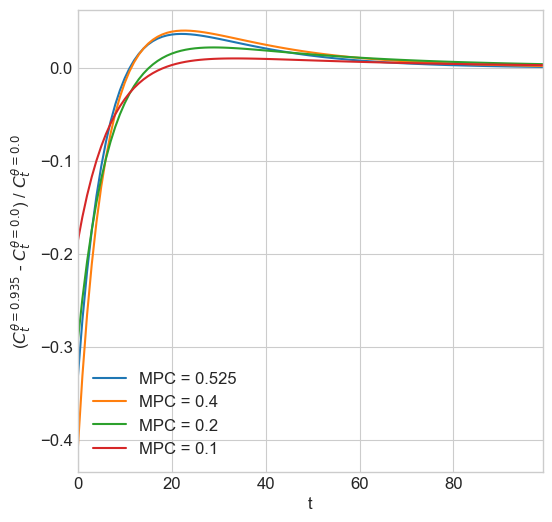

In [34]:
max_T = 100
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6 * 1, 6 * 1), dpi=100)
for i_m, m in enumerate(model_list):
    ss_value = m.ss.__dict__['y']
    shock_series =  0.01*ss_value*0.95**np.arange(m.par.T)

    jac = m.jac_hh[('C_hh', 'ey')].copy()
    IRF_abs_no_sticky = jac @ shock_series
    # IRF_perc_no_sticky = (IRF_abs_no_sticky / ss_value) * 100

    jac = model_list_sticky[i_m].jac_hh[('C_hh', 'ey')].copy()
    IRF_abs_sticky = jac @ shock_series
    # IRF_perc_sticky = (IRF_abs_sticky / ss_value) * 100

    IRF_perc = (IRF_abs_sticky - IRF_abs_no_sticky) / (IRF_abs_no_sticky + ss_value) * 100

    ax.plot(np.arange(max_T), IRF_perc[:max_T], label=label_list[i_m], linestyle='-')

ax.legend()
ax.set_ylabel('($C_t^{\\theta=0.935}$ - $C_t^{\\theta=0.0}$) / $C_t^{\\theta=0.0}$')
ax.set_xlabel('t')
plt.xlim(xmin=0.0, xmax=max_T-1)
# plt.ylim(ymin=0.0)